https://www.kaggle.com/datasets/kazanova/sentiment140

In [1]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

data = pd.read_csv('../1/Hotel Reservations.csv')

data = data.drop('Booking_ID', axis=1)

categorical_cols = data.select_dtypes(exclude=['int', 'float']).columns

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
encoded_data = ohe.fit_transform(data[categorical_cols[:-1]])
encoded_data.head()

data = pd.concat([data, encoded_data], axis=1).drop(columns=categorical_cols[:-1])

data['booking_status'] = data['booking_status'].replace({'Not_Canceled': 0, 'Canceled': 1})

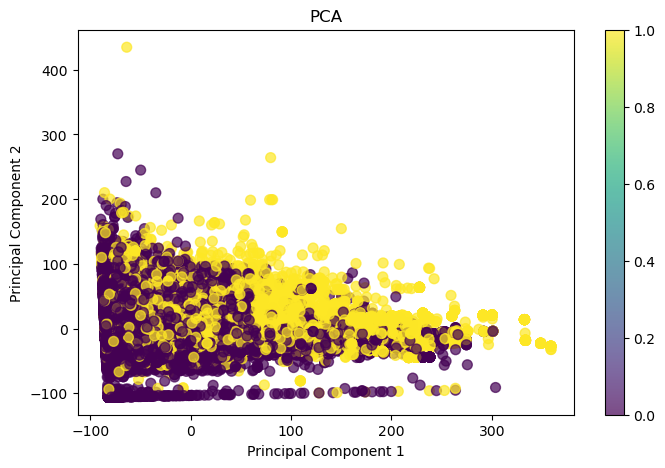

In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

plt.figure(figsize=(8, 5))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=data['booking_status'], cmap='viridis', s=50, alpha=0.7)
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.show()

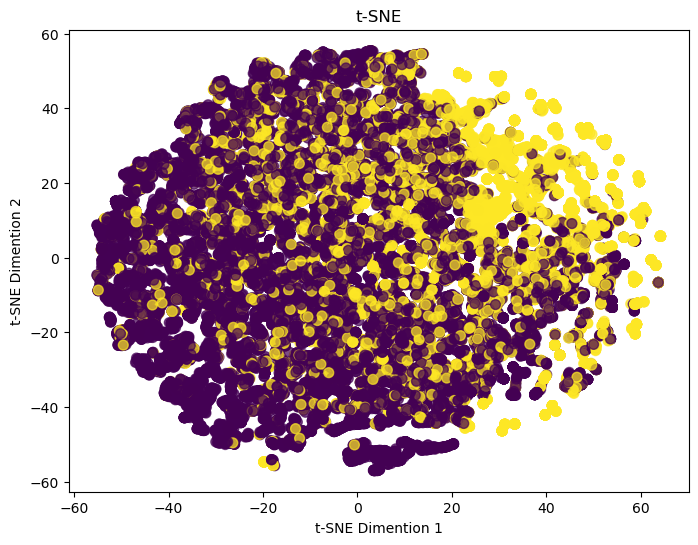

In [3]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=500)
data_tsne = tsne.fit_transform(data)

plt.figure(figsize=(8, 6))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=data['booking_status'], cmap='viridis', s=50, alpha=0.7)
plt.xlabel('t-SNE Dimention 1')
plt.ylabel('t-SNE Dimention 2')
plt.title('t-SNE')
plt.show()

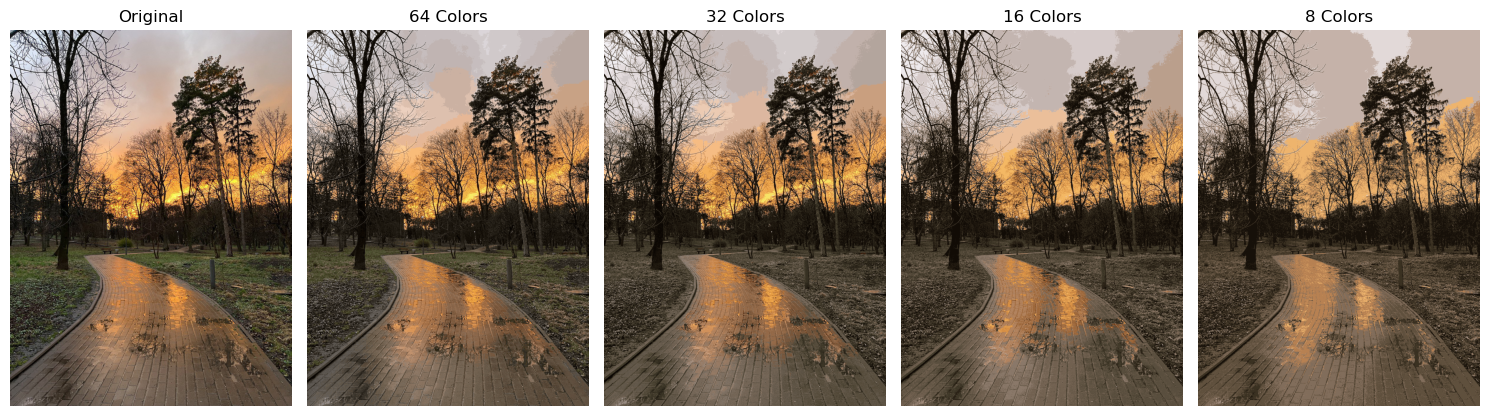

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import io

image = io.imread('spring.jpg')
image = image / 255.0

h, w, c = image.shape
pixels = image.reshape(-1, 3)

def quantize_image(pixels, n_colors):
    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(pixels)
    
    new_pixels = kmeans.cluster_centers_[kmeans.labels_]
    quantized_image = new_pixels.reshape(h, w, c)
    return quantized_image

levels = [64, 32, 16, 8]
fig, axes = plt.subplots(1, len(levels) + 1, figsize=(15, 5))

axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis('off')

for i, level in enumerate(levels):
    quantized_img = quantize_image(pixels, level)
    axes[i + 1].imshow(quantized_img)
    axes[i + 1].set_title(f"{level} Colors")
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()

In [9]:
import re
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')

data = pd.read_csv("sentiment140.csv", encoding='latin-1', usecols=[0, 5], names=['target', 'text'])
data['target'] = data['target'].apply(lambda x: 'positive' if x == 4 else 'negative')

stop_words = set(stopwords.words('english'))
list(stop_words)[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Moony\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['before', 'such', 'off', 'both', 'myself', 'that', 's', 'which', 'm', 'while']

In [10]:
data.head()

,target,text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...
2,negative,@Kenichan I dived many times for the ball. Man...
3,negative,my whole body feels itchy and like its on fire
4,negative,"@nationwideclass no, it's not behaving at all...."


In [13]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\d+', '', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

data['clean_text'] = data['text'].apply(clean_text)

In [14]:
data.head()

,target,text,clean_text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats bummer shoulda got david carr third...
1,negative,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,negative,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest go bounds
3,negative,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,negative,"@nationwideclass no, it's not behaving at all....",behaving im mad cant see


In [15]:
positive_text = " ".join(data[data['target'] == 'positive']['clean_text'])
negative_text = " ".join(data[data['target'] == 'negative']['clean_text'])

In [27]:
positive_text[:100]

'love u guys r best im meeting one besties tonight cant wait girl talk thanks twitter add sunisa got '

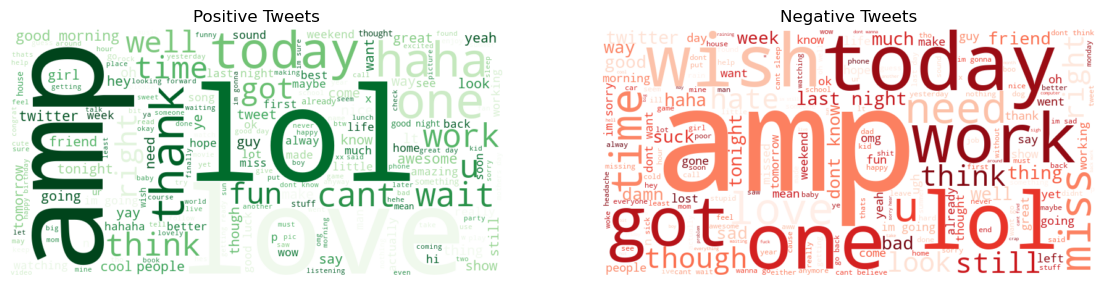

In [29]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Tweets")

plt.subplot(1, 2, 2)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Tweets")

plt.show()

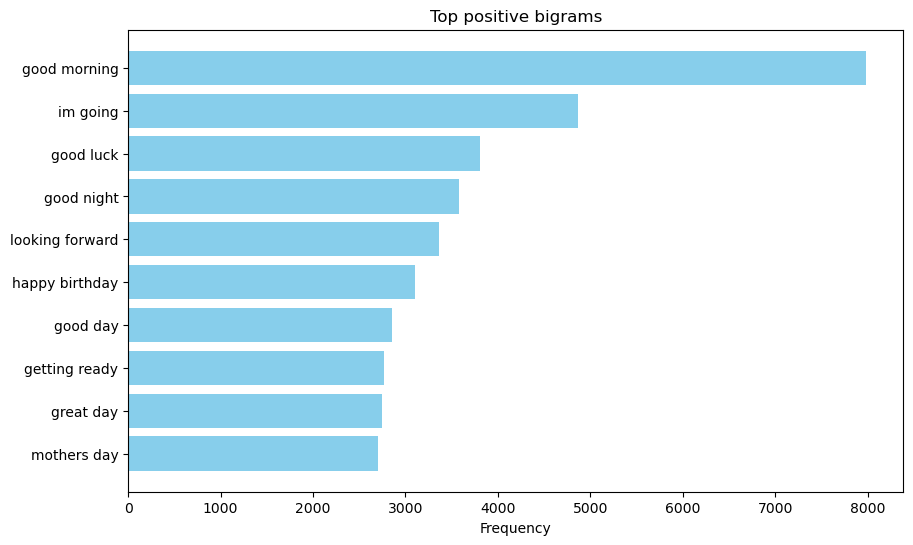

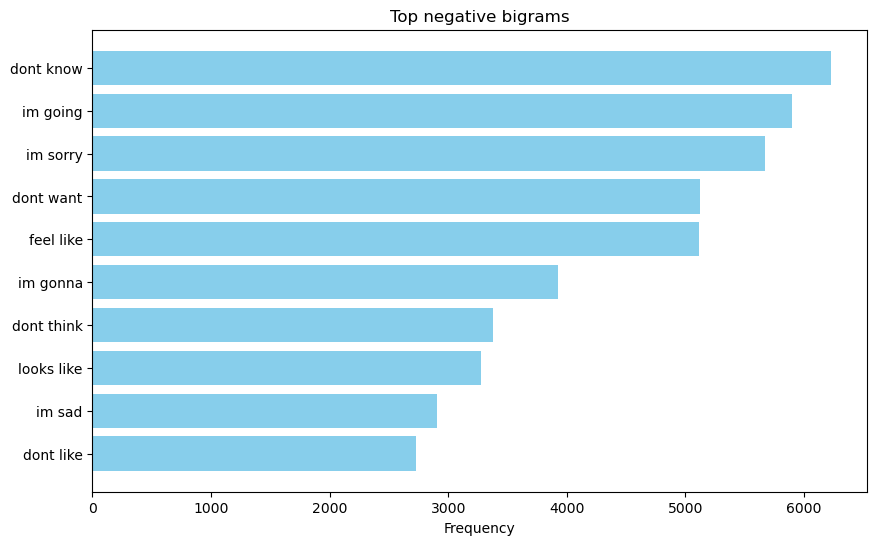

In [30]:
def plot_top_ngrams(text, n=2, ngram_range=(2, 2), top_n=10, title="Top N-grams"):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(text)
    counts = X.sum(axis=0).A1
    ngrams = vectorizer.get_feature_names_out()
    ngram_counts = pd.DataFrame({'ngram': ngrams, 'count': counts}).nlargest(top_n, 'count')

    plt.figure(figsize=(10, 6))
    plt.barh(ngram_counts['ngram'], ngram_counts['count'], color='skyblue')
    plt.xlabel("Frequency")
    plt.title(f"{title}")
    plt.gca().invert_yaxis()
    plt.show()

plot_top_ngrams(data[data['target'] == 'positive']['clean_text'], n=2, ngram_range=(2, 2), top_n=10, title="Top positive bigrams")
plot_top_ngrams(data[data['target'] == 'negative']['clean_text'], n=2, ngram_range=(2, 2), top_n=10, title="Top negative bigrams")

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['clean_text'])

y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.773828125

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.75      0.77    159494
    positive       0.76      0.80      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000

